# 1.4  Регуляризация 

In [1]:
import numpy as np
import scipy.linalg as la
import scipy.interpolate as interp
import scipy.integrate as integrate
import matplotlib.pyplot as plt

### Функции вычисления коэффициентов разложения

In [31]:
# x(n), y(n) - массив данных
# m - степень полинома (количество базисных функций - 1)

def SqLeast (x, y, m):
    global G, Phi
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    G = PhiT @ Phi
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a

def SqLeastRegRidge (x, y, m, alpha):
    
    # polinomial approximation with L2 (Tikhonov) regularization
    # x, y - data set
    # m - polinom degree 
    
    global G
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    
    RegAlpha = np.eye (m+1) * alpha
        
    G = PhiT @ Phi + RegAlpha 
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a


def SqLeastRegLasso (x, y, m, alpha):
    
    # polinomial approximation with L1 (lasso) regularization
    # x, y - data set
    # m - number of basis functions (polinom degree + 1)
    
    global G, Phi
    
    n = len(x)
    yr = np.eye (n)
    E = np.eye (n)
    W = np.eye (m+1)
    
    
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    
    # initial stage
          
    G = PhiT @ Phi 
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    
    yr = y @ E 
    
    eps = 0.001
    
    # iteration procedure
    
  #  print ()
  #  print ('Итерационный процесс')
  #  print ()
    
    for it in range (0, 20):
    
        ait = a            
          
        for j in range (0, m+1):
            W[j,j]=1./abs(ait[j]) #**2
           
                    
        RegAlpha = W * alpha
        G = PhiT @ Phi + RegAlpha
        z = PhiT @ yr
        a = np.linalg.solve(G, z)
        
        eit = a - ait
        epsit = (sum(eit**2))**0.5/len(eit)
        
        # print ('iteration', it, a, epsit)
        
        if (epsit<=eps):
            print ()
            break 
                
    return a


def BasicFunctions (num, x):
    PhiFun = x**num
    return PhiFun

def SqLeast_mD (Xm, y):
    
    # Linear Regression in m-dimensional space 
    # Xm, y - data set
    
    global G, Phi
    
    n, m = Xm.shape
    
    #print (Xm.shape)
    Phi = np.zeros ((n,m))
    #Phi [:,0] = 1.
    for k in range (0, m):
        Phi[:,k] = Xm[:,k]
    PhiT = Phi.T
    G = PhiT @ Phi
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a

def SqLeast_mD_Ridge (Xm, y, alpha):
    
    # Linear Regression in m-dimensional space 
    # Xm, y - data set
    # alpha - regularization parameter, ridge regression
    
    global G, Phi
    
    n, m = Xm.shape
    Phi = np.zeros ((n,m))
    
    for k in range (0, m):
        Phi[:,k] = Xm[:,k]
    PhiT = Phi.T
    
    RegAlpha = np.eye (m) * alpha
    
    G = PhiT @ Phi + RegAlpha
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    
    return a

def SqLeast_mD_Lasso (Xm, y, alpha):
    
    # Linear Regression in m-dimensional space 
    # Xm, y - data set
    # alpha - regularization parameter, lasso regression
    
    global G, Phi
    n, m = Xm.shape
    Phi = np.zeros ((n,m))
    
    yr = np.eye (n)
    E = np.eye (n)
    W = np.eye (m)
    
    # initial stage
    
    for k in range (0, m):
        Phi[:,k] = Xm[:,k]
    PhiT = Phi.T

    G = PhiT @ Phi 
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    
    yr = y @ E 
    
    eps = 0.001
    
    # iteration procedure
    
    for it in range (0, 20):
    
        ait = a            
          
        for j in range (0, m):
            W[j,j]=1./abs(ait[j]) 
           
                    
        RegAlpha = W * alpha
        G = PhiT @ Phi + RegAlpha
        z = PhiT @ yr
        a = np.linalg.solve(G, z)
        
        eit = a - ait
        epsit = (sum(eit**2))**0.5/len(eit)
        
     #   print ('iteration', it, a, epsit)
        
        if (epsit<=eps):
            #print ()
            break 
            
    return a        

### Функция вычисления погрешности аппроксимации

In [32]:
def AppError (x,y,Coefs):
    
    PolynomValue = np.zeros(len(x))
    for i in range (0, m+1):
        PolynomValue += Coefs[i]*x**i
   
    y_av = np.sum(y)/len(x)
    y_disp = np.sum((y-y_av)**2)/len(x)
    
    ResLocal = (y - PolynomValue)
    ResLocalRel = ResLocal/y_disp**0.5
    ResGlobal = (np.sum ((ResLocal)**2)/len(x))**0.5
    ResGlobalRel = ResGlobal / y_disp**0.5
    
    yv_disp = np.sum((PolynomValue-y_av)**2)/len(x)
    
    R2 = yv_disp/y_disp
        
    return ResLocal, ResLocalRel, ResGlobal, ResGlobalRel

def R2 (x, y, Coefs):
    PolynomValue = np.zeros(len(x))
    
    for i in range (0, m+1):
        PolynomValue += Coefs[i]*x**i
   
    y_av = np.sum(y)/len(x)
    y_disp = np.sum((y-y_av)**2)/len(x)    
      
    yv_disp = np.sum((PolynomValue-y_av)**2)/len(x)
    
    R2 = yv_disp/y_disp
        
    return R2

## Квазиреальный эксперимент 1. Полиномиальная 1D аппроксимация.

Коэффициенты точные [-1.   1.   2.   1.  -1.  -0.5]

Коэффициенты МНК [-1.13894984  1.20486729  3.37464608 -1.95876636  0.974185   -0.9289315 ]
Число обусловленности 12373162.973423935

Коэффициенты МНК с L2 регуляризацией [-1.15728259  1.72810177  1.47267027  0.48447397 -0.32912442 -0.68218855]
Число обусловленности 369807.6341307769


Коэффициенты МНК с L1 регуляризацией [-1.16371148e+00  1.70059252e+00  1.74654277e+00  1.62213676e-09
 -1.87511005e-02 -7.48790662e-01]
Число обусловленности 3072111.146552153

Коэффициенты МНК SVD [-1.17666575  1.80893808  1.38099097  0.53289277 -0.34692996 -0.67829036]

Сингулярные числа [6.17413874e+01 6.54357569e+00 2.56943786e+00 7.10994096e-01
 1.39866108e-01 1.75523802e-02]


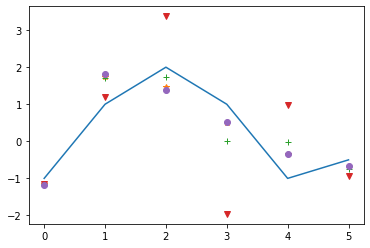

In [34]:
xleft = 0.0
xright = 2.0
n = 24
x = np.linspace(xleft,xright,n)
yf = np.zeros ((n))
y = np.zeros ((n))

coefs = np.array ([-1, 1, 2, 1,-1,-0.5])
m = len(coefs)- 1

print ('Коэффициенты точные', coefs)
print()

for i in range (0, m+1):
    yf += coefs[i]*x**i
#plt.plot (x,yf, 'o')

Delta = 0.1 * np.random.randn(len(x))
y = yf + Delta
#plt.plot (x, y, '*')

PolynomCoefs = SqLeast (x, y, m)
print ('Коэффициенты МНК', PolynomCoefs)

#print ('Gmatrix',G)
cond = np.linalg.cond (G)
print ('Число обусловленности', cond)

print()

PolynomValue = np.zeros(len(x))
for i in range (0, m+1):
    PolynomValue += PolynomCoefs[i]*x**i
        
#plt.plot (x, y, 'o')
#plt.plot (x, PolynomValue)
#plt.subplot (x, ErrorLocal)

CoefsRegRidge = SqLeastRegRidge (x, y, m, 0.01)
print ('Коэффициенты МНК с L2 регуляризацией', CoefsRegRidge)
cond = np.linalg.cond (G)
print ('Число обусловленности', cond)
print()

PolynomValue = np.zeros(len(x))
for i in range (0, m+1):
    PolynomValue += CoefsRegRidge[i]*x**i
#plt.plot (x, PolynomValue)

CoefsRegLasso = SqLeastRegLasso (x, y, m, 0.01)
print ('Коэффициенты МНК с L1 регуляризацией', CoefsRegLasso)
cond = np.linalg.cond (G)
print ('Число обусловленности', cond)
print()

PhiInv = np.linalg.pinv(Phi, rcond = 1e-2)
CoefsSVD = PhiInv @ y
print ('Коэффициенты МНК SVD', CoefsSVD )
print()

U, s, Vh = np.linalg.svd(Phi)
print ('Сингулярные числа', s)

plt.plot (coefs)
plt.plot (CoefsRegRidge, '*')
plt.plot (CoefsRegLasso, '+')
plt.plot (PolynomCoefs, 'v')
plt.plot (CoefsSVD, 'o')

## Квазиреальный эксперимент 2. Линейная m-мерная регрессия.

In [30]:
n=100; m=3

Xm = np.zeros((n,m))

Xm[:,0] = np.random.random(n)
Xm[:,1] = np.random.random(n)
Xm[:,2] = 1.*Xm[:,0] + 1.* Xm [:,1] + 0.001 * np.random.randn(n)   # create bad condition
#Xm[:,2] = np.random.random(n)

coefs = np.array ([1, 0, 1])
yf = np.dot(Xm,coefs) 
y = yf + 0.01 * np.random.randn(n)
print ('y_error', (np.sum(yf-y)**2)**0.5)
print ()

#print (Xm)
print ('condition', np.linalg.cond(Xm))
#print ()

CoefsSq = SqLeast_mD (Xm, y)

CoefsLasso = SqLeast_mD_Lasso (Xm, y, 0.001)

CoefsRidge = SqLeast_mD_Ridge (Xm, y, 0.001)

PhiInv = np.linalg.pinv(Phi, rcond = 1.e-3)
CoefsSVD = PhiInv @ y

ypredictSq = np.dot(Phi, CoefsSq)
ypredictRidge = np.dot(Phi, CoefsRidge)
ypredictLasso = np.dot(Phi, CoefsLasso)
ypredictSVD = np.dot(Phi, CoefsSVD)

print ('Linear Model Parameters')
print ('Exact', coefs)
print ('SqLeast', CoefsSq)
print ('Ridge', CoefsRidge)
print ('Lasso', CoefsLasso)
print ('SVD', CoefsSVD)
#print (ypredict)

print ()

print ('RSS Sq', (np.sum(ypredictSq-y)**2)**0.5)
print ('RSS Ridge', (np.sum(ypredictRidge-y)**2)**0.5)
print ('RSS Lasso', (np.sum(ypredictLasso-y)**2)**0.5)
print ('RSS SVD', (np.sum(ypredictSVD-y)**2)**0.5)

print ()

print ('Error Sq', (np.sum(CoefsSq-coefs)**2)**0.5)
print ('Error Ridge', (np.sum(CoefsRidge-coefs)**2)**0.5)
print ('Error Lasso', (np.sum(CoefsLasso-coefs)**2)**0.5)
print ('Error SVD', (np.sum(CoefsSVD-coefs)**2)**0.5)

y_error 0.00672251341068103

condition 2058.927976241083

Linear Model Parameters
Exact [1 0 1]
SqLeast [1.39313743 0.39926372 0.60298793]
Ridge [1.01023107 0.01664282 0.98577048]
Lasso [9.93610297e-01 2.54746160e-05 1.00239058e+00]
SVD [0.99653249 0.0028419  0.99953043]

RSS Sq 0.08448409942747276
RSS Ridge 0.0835839486154499
RSS Lasso 0.0835191308254693
RSS SVD 0.08260715721804668

Error Sq 0.3953890778416441
Error Ridge 0.012644362996660878
Error Lasso 0.003973648973350057
Error SVD 0.0010951857043002278
